In [15]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from naplab.frame_data import read_timestamps
from naplab.gps import process_gps_data
from utils import plot_coordinates
from interpolate import GPSPointDataset, train_model, predict, device, CoordinatePredictionModel
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# load training data
# Train the model
gps_left = process_gps_data("./Trip094/gnss094_50.txt")
gps_right = process_gps_data("./Trip094/gnss094_52.txt")

train_dataset_left = GPSPointDataset(gps_left)
train_dataset_right = GPSPointDataset(gps_right)

train_loader_left = torch.utils.data.DataLoader(
    train_dataset_left,
    batch_size=len(train_dataset_left.data),
    shuffle=True,
    #pin_memory=True,
)

train_loader_right = torch.utils.data.DataLoader(
    train_dataset_right,
    batch_size=len(train_dataset_right.data),
    shuffle=True,
    #pin_memory=True,
)

Epoch 300000, Train Loss: 0.00005396, Train RMSE: 0.00734561, Best RMSE: 0.00725146, Optimizer LR: [0.0004971239399803606]


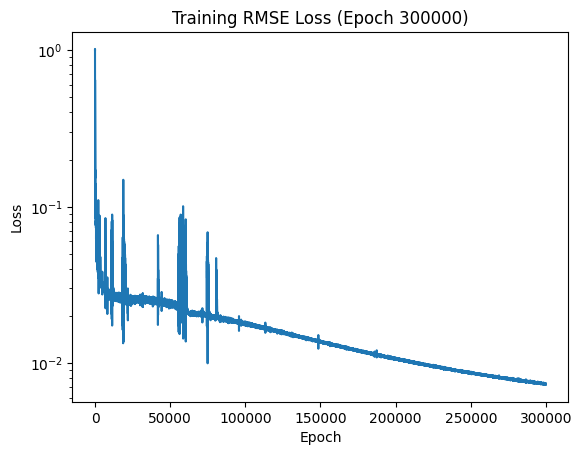

100%|██████████| 300000/300000 [2:41:23<00:00, 30.98it/s]


In [9]:
# TRAINING CUSTOM MODEL

input_dim = 1  # Dimensionality of input timestamps
output_dim = 3  # Dimensionality of XYZ coordinates
hidden_dim = 128
num_epochs = 300000

model_left = CoordinatePredictionModel(input_dim, hidden_dim, output_dim=output_dim)
optimizer = optim.AdamW(model_left.parameters(), lr=.01)
scheduler = StepLR(optimizer, step_size=100, gamma=0.999)

train_model(model_left, train_loader_right, optimizer, scheduler, num_epochs, "./models/best_model_left.pth")


Epoch 800, Train Loss: 0.00454606, Train RMSE: 0.06742446, Best RMSE: 0.06672139, Optimizer LR: [0.009920279440699441]


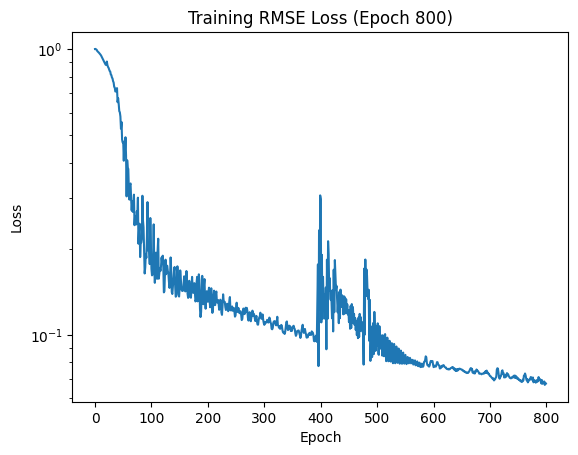

  0%|          | 803/300000 [00:24<3:13:33, 25.76it/s]

In [17]:
# TRAIN RIGHT GPS
input_dim = 1  # Dimensionality of input timestamps
output_dim = 3  # Dimensionality of XYZ coordinates
hidden_dim = 128
num_epochs = 300000
model_right = CoordinatePredictionModel(input_dim, hidden_dim, output_dim=output_dim)
optimizer = optim.AdamW(model_right.parameters(), lr=.01)
scheduler = StepLR(optimizer, step_size=100, gamma=0.999)

train_model(model_right, train_loader_right, optimizer, scheduler, num_epochs, "./models/best_model_right.pth")

In [ ]:
input_dim = 1  # Dimensionality of input timestamps
output_dim = 3  # Dimensionality of XYZ coordinates
hidden_dim = 128

model_left = CoordinatePredictionModel(input_dim, hidden_dim, output_dim=output_dim)
model_right = CoordinatePredictionModel(input_dim, hidden_dim, output_dim=output_dim)
model_left.load_state_dict(torch.load("./models/best_model_left.pth"))
model_left.eval()
model_right.load_state_dict(torch.load("./models/best_model_right.pth"))
model_right.eval()

CoordinatePredictionModel(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=3, bias=True)
  )
)

Number of GPS points:  100 Number of timestamps:  300


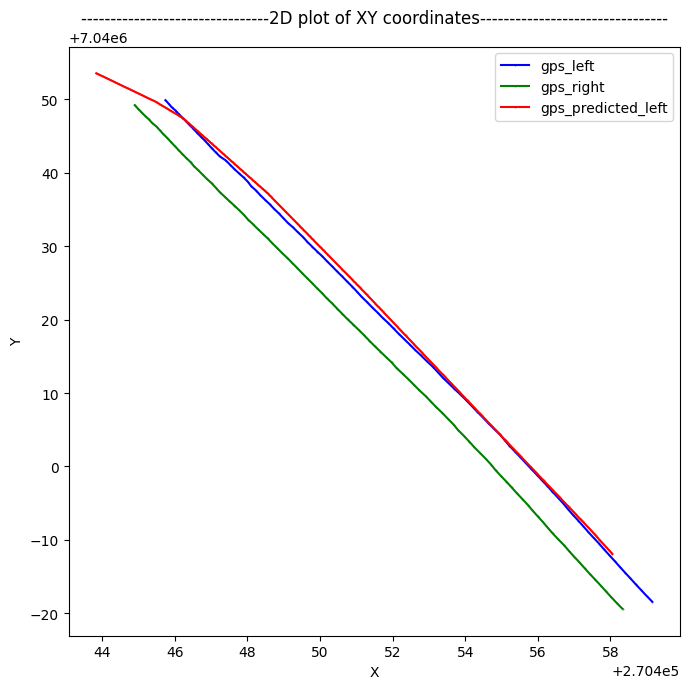

In [ ]:
max_gps = 100
# timestamps based on C5_R1 video
timestamps = read_timestamps("./Trip094/C5_R1.h264.timestamps")
max_ts = max_gps * 3 if max_gps != -1 else -1

print("Number of GPS points: ", max_gps, "Number of timestamps: ", max_ts)

# Predict left GPS
norm_t_left = np.array([train_dataset_left.normalize_1_timestamp(timestamp) for timestamp in timestamps[:max_ts]]).reshape(-1, 1)
pred_pos_left = predict(model_right, torch.tensor(norm_t_left, dtype=torch.float32).to(device))
predicted_gps_left = train_dataset_left.denormalize_position(pred_pos_left.numpy())

# Predict right GPS
norm_t_right = np.array([train_dataset_right.normalize_1_timestamp(timestamp) for timestamp in timestamps[:max_ts]]).reshape(-1, 1)
pred_pos_right = predict(model_right, torch.tensor(norm_t_right, dtype=torch.float32).to(device))
predicted_gps_right = train_dataset_right.denormalize_position(pred_pos_right.numpy())

gps_left_pos = [point.position for point in gps_left[:max_gps]]
gps_right_pos = [point.position for point in gps_right[:max_gps]]

plot_coordinates([gps_left_pos, gps_right_pos, predicted_gps_left, predicted_gps_right],
        labels=["gps_left", "gps_right", "gps_predicted_left", "gps_predicted_right"], figsize=(7, 7), is3D=False, show_scatter=False)